###Source Code
On my [GitHub](https://github.com/fierval/retina/tree/master/DiabeticRetinopathy/Refactoring/kobra/dr)
This code is wrapped in a class which makes it harder to post to a Notebook (a few too many lines for a post).

###Segmenting Fundus Images with kNN

After preprocessing the images as described in a previous post, I tried to extract learnable features by applying the _k-nearest neighbors_ algorithm.
In order to seed the cluster I have applied my (immense) domain knowledge in the area of retinology. I used the annotations tool that comes with OpenCV. It resides in the _applications_ folder of the OpenCV project created with CMake and built with Visual Studio 2013.

I ran the tool on a small set of images and selected the following regions (to the best of my knowledge acquired after reading articles on retinopathy and watching slides). This produces a text file where each line has the following format:

**annotations\1196_right.jpeg** $\color{green}{10\ 1318\ 182\ 22}\color{red}{\ 12\ 1356\ 195\ 8}$...

Here after the name of the file are the coordinates of annotated rectangles, where each rectangle is a 4-tuple: $(x, y, \Delta x, \Delta y)$, where $(x, y)$ are the coordinates of the left top corner and the rest are lenghts of the sides of the rectangle.

I have annotated 10 rectangles in the following order:

- 0 - 1: drusen/exudates 
- 2 - 3: texture 
- 4 - 5: Camera effects
- 6 - 7: Haemorages/blood vessels
- 8 - 9: Optic Disc

and did these annotations for 7 images selected at random

I used k-nearest neighbors algorithm to segment each image:

In [17]:
%matplotlib inline
import matplotlib.pylab as plt
%run "../regions_detect_knn.py"

In [18]:
# path to the images preprocessed by histogram specification from 16_left.jpeg
root = '/kaggle/retina/train/labelled' # root of a tree, where each subdirectory is a class label of the image (0 - 4)
annotations = 'annotations.txt' # annotations file
masks_dir = '/kaggle/retina/train/masks' # masks produced during preprocessing, identifying the eye
im_file = '4/16_left.jpeg' # preprocessed image

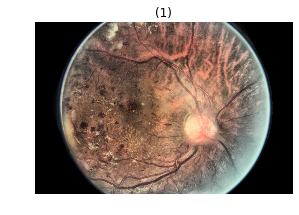

In [19]:
knn = KNeighborsRegions(root, im_file, annotations, masks_dir, n_neighbors = 3)
show_images([knn._image])

In order to seed the clusters, I read the annotatations from all ten regions of the seven files, and for each region stacked them together, averaged the images and then averaged the resulting image. I thus obtained a 1x1 seed for each of the 5 classes I wanted to learn, 2 seeds for each class (i.e., in the current scheme of things, two neighbors vote for the same class) :

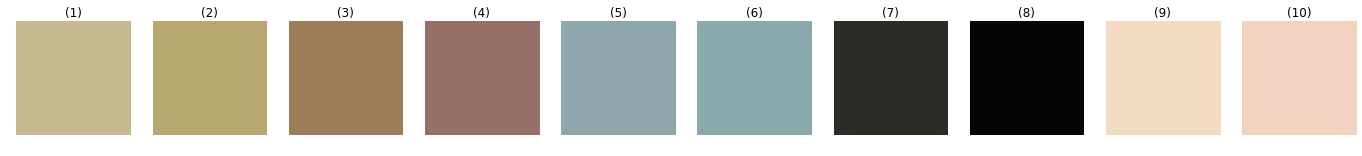

In [20]:
# these functions are not called directly by users of the class
knn._rects = np.array([])
knn._avg_pixels = np.array([])
knn._process_annotations()
knn._get_initial_classes()
# this is what our seeds look like
knn.display_average_pixels()

(These do look like swatches of fabric or paint samples...)

Now we simply apply the KNeighborsClassifier() from scikit-learn to learn our classes:

In [21]:
# first need to set the class labels
knn.labels = [Labels.Drusen, Labels.Drusen, Labels.Background, Labels.Background, 
                    Labels.CameraHue, Labels.CameraHue, 
                    Labels.Haemorage, Labels.Haemorage, Labels.OD, Labels.OD]
segments = knn.analyze_image()

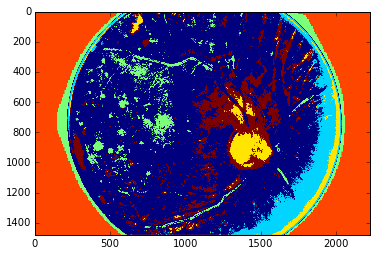

In [24]:
# segmented image
plt.imshow(segments)
plt.show()

Let's see how we did on regions of interest (drusen, haemorages):

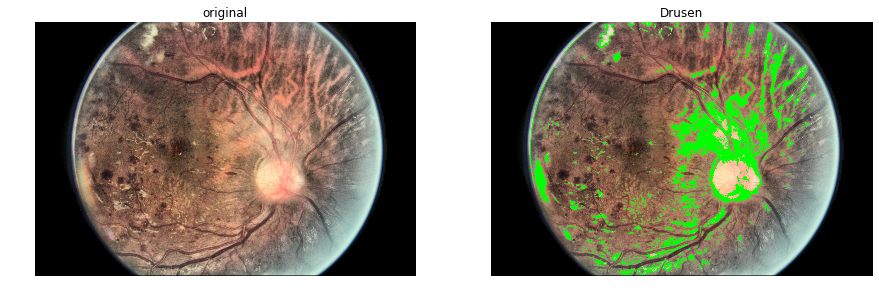

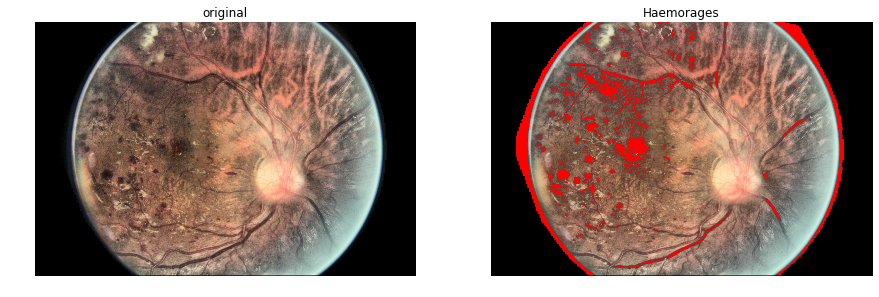

In [26]:
knn.display_artifact(segments, Labels.Drusen, (0, 255, 0), "Drusen")
knn.display_artifact(segments, Labels.Haemorage, (0, 0, 255), "Haemorages")

So kinda ok but very far from ideal. The "Drusen" image shows lots and lots of false positives and the haemorages image includes blood vessels and fovea. I took some steps to resolve these problems (detecting blood vessels, removing bright areas adjacent to the optical disk), but either there was not enough time or the selected methodology was not suitable for this, I was not very succesful at coming up with good features this way.

Nevertheless, in the words of my former colleage (a scientist): "succesful experiment with negative results".